# Install Julia

In [3]:
%%shell
set -e
# Adapted from https://github.com/ageron/julia_notebooks
#---------------------------------------------------#
JULIA_VERSION="1.10.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.10.2 on the current Colab Runtime...
2024-05-12 09:30:53 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.10/julia-1.10.2-linux-x86_64.tar.gz [169654402/169654402] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Packages

In [244]:
import Pkg
Pkg.add("Gen")
Pkg.add("Plots")
Pkg.add("StatsBase")
Pkg.add("StatsPlots")
Pkg.add("Distributions")
Pkg.add("StatsFuns")
#Pkg.add("Luxor")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
#import Random, Logging
using Gen, Plots, Distributions, StatsPlots, LinearAlgebra, StatsFuns
using StatsBase: mean, countmap

# RSA model: Politeness

## The case study of white lies

### L0

In [86]:
# Define state and utterance space
states = [1, 2, 3, 4, 5]
utterances = ["terrible", "bad", "okay", "good", "amazing"]
key_mapping = Dict("terrible" => 1, "bad" => 2, "okay" => 3, "good" => 4, "amazing" => 5)

# Literal semantics represented as probabilities
literalSemantics = Dict(
    "terrible" => [0.95, 0.85, 0.02, 0.02, 0.02],
    "bad" => [0.85, 0.95, 0.02, 0.02, 0.02],
    "okay" => [0.02, 0.25, 0.95, 0.65, 0.35],
    "good" => [0.02, 0.05, 0.55, 0.95, 0.93],
    "amazing" => [0.02, 0.02, 0.02, 0.65, 0.95]
)

prob(utterance::String, state::Int64) = literalSemantics[utterance][state]
@dist meaning(utterance::String, state::Int64) = bernoulli(prob(utterance, state))

@dist uniformDraw(vector::Vector, vectorProbs::Vector{Float64}) = vector[categorical(vectorProbs)]
uniformProbs(vector::Vector) = fill(1 / length(vector), length(vector))
stateProbs = uniformProbs(states)
utterancesProbs = uniformProbs(utterances)

5-element Vector{Float64}:
 0.2
 0.2
 0.2
 0.2
 0.2

In [87]:
@gen function literalListener(stateProbs::Vector{Float64}, utterance::String)

    state = @trace(uniformDraw(states, stateProbs), :state)
    m = @trace(meaning(utterance, state), :m)
    return state

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}, String], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##literalListener#307", Bool[0, 0], false)

In [97]:
"""
    enum_inference(model, model_args, observations, latent_addrs, latent_values)

Runs enumerative Bayesian inference for a `model` parameterized by `model_args`,
conditioned on the `observations`. Given a list of `latent_addrs` and the
a list of corresponding `latent_values` that each latent variable can take on,
we enumerate over all possible settings of the latent variables.

Returns a named tuple with the following fields:
- `traces`: An array of execution traces for each combination of latent values.
- `logprobs`: An array of log probabilities for each trace.
- `latent_logprobs`: A dictionary of log posterior probabilities per latent.
- `latent_probs`: A dictionary of posterior probabilities per latent.
- `lml`: The log marginal likelihood of the observations.

Source: This implementation was taken and modified from the implementation
of Cooperative Language-Guided Inverse Plan Search (CLIPS) from MIT's
Probabilistic Computing Lab: https://github.com/probcomp/CLIPS.jl
"""
function enum_inference(
    model::GenerativeFunction, model_args::Tuple,
    observations::ChoiceMap, latent_addrs, latent_values
)
    @assert length(latent_addrs) == length(latent_values)
    # Construct iterator over combinations of latent values
    latents_iter = Iterators.product(latent_values...)
    # Generate a trace for each possible combination of latent values
    traces = map(latents_iter) do latents
        constraints = choicemap()
        for (addr, val) in zip(latent_addrs, latents)
            constraints[addr] = val
        end
        constraints = merge(constraints, observations)
        tr, _ = generate(model, model_args, constraints)
        return tr
    end
    # Compute the log probability of each trace
    logprobs = map(Gen.get_score, traces)
    # Compute the log marginal likelihood of the observations
    lml = logsumexp(logprobs)
    # Compute the (marginal) posterior probabilities for each latent variable
    latent_logprobs = Dict(
        addr => ([logsumexp(lps) for lps in eachslice(logprobs, dims=i)] .- lml)
        for (i, addr) in enumerate(latent_addrs)
    )
    latent_probs = Dict(addr => exp.(lp) for (addr, lp) in latent_logprobs)
    return (
        traces = traces,
        logprobs = logprobs,
        latent_logprobs = latent_logprobs,
        latent_probs = latent_probs,
        latent_addrs = latent_addrs,
        lml = lml
    )
end

enum_inference

In [125]:
# Define observed actions
utterance = "good"  # The observed utterance
observations = choicemap((:m, 1))  # Observing that m is true

# Run inference by enumerating over all possible states
results = enum_inference(
    literalListener,
    (utterancesProbs, utterance),
    observations,
    (:state, ),  # latent addresses
    (states, )
)

# Print inferred state probabilities
println("Inferred state probabilities given that the utterance was `good` and m=true:")
for (state, prob) in zip(states, results.latent_probs[:state])
    println("State $state: Probability $prob")
end


Inferred state probabilities given that the utterance was `good` and m=true:
State 1: Probability 0.008000000000000004
State 2: Probability 0.02000000000000001
State 3: Probability 0.22
State 4: Probability 0.37999999999999995
State 5: Probability 0.37200000000000005


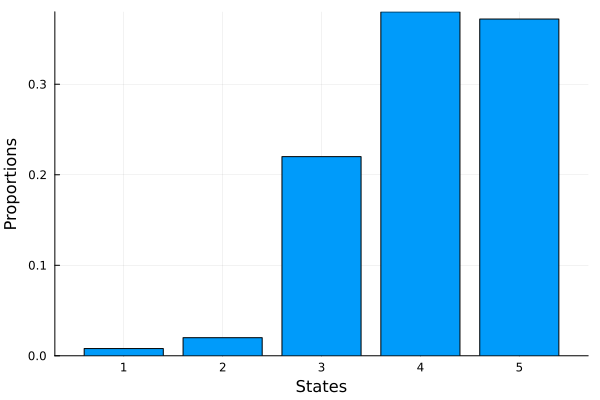

In [126]:
bar(states, results.latent_probs[:state], xlabel="States", ylabel="Proportions", legend=false)

### S1

In [74]:
lambda_ = 1.25
social(proportions::Dict, valueFunctionLambda) = sum(key * value for (key, value) in proportions) * valueFunctionLambda
state_logProb(L0_post::Dict, state::Int64) = log(L0_post[state])

state_logProb (generic function with 1 method)

In [130]:
@gen function S1_utility(utterance::String, state::Int, phi::Float64)
    alpha_ = 10
    L0_post = enum_inference(
                  literalListener,
                  (utterancesProbs, utterance),
                  choicemap((:m, 1)),
                  (:state, ),
                  (states, )
              )
    L0 = Dict(key => value for (key, value) in zip(states, L0_post.latent_probs[:state]))
    utility_epistemic = state_logProb(L0, state)
    utility_social = social(L0, lambda_)
    speakerUtility = phi * utility_epistemic + (1 - phi) * utility_social
    return alpha_ * speakerUtility
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[String, Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##S1_utility#329", Bool[0, 0, 0], false)

In [251]:
"""
    speaker_log_probs(utterances::Array{String}, utterProbs::Array{Float64}, speakerUtil::Gen.DynamicDSLFunction, utilArgs::Tuple)

Calculate the adjusted probabilities of each utterance based on their initial probabilities and utility.
# Arguments
- utterances: Array{String} - A list of possible utterances.
- utterProbs: Array{Float64} - A list containing the probability of each utterance, corresponding to the `utterances` array.
- utilArgs: Tuple - A tuple of input parameters to calculate the utility value of each utterance.
- speakerUtil: DynamicDSLFunction - A function that takes an utterance and other necessary arguments as input and returns the utility value for that utterance.
# Output
- newProbs: Array{Float64}: An array containing the adjusted probabilities of each utterance. The probabilities are adjusted by adding
the utility of each utterance to the its original log probability.
"""

function speaker_log_probs(utterances::Array{String}, utterProbs::Array{Float64}, speakerUtil::Gen.DynamicDSLFunction, utilArgs::Tuple)

    # Calculate utility-adjusted probabilities
    adjusted_probs = Float64[]  # Initialize an empty array to store results

    for (utterance, prob) in zip(utterances, utterProbs)
        utility = speakerUtil(utterance, utilArgs...)
        log_prob = log(prob)  # Compute log of the probability
        adjusted_prob = exp(log_prob + utility)  # Combine and exponentiate
        push!(adjusted_probs, adjusted_prob)  # Append to results array
    end

    # Normalize the probabilities to sum to 1
    total_sum = sum(adjusted_probs)
    normalized_probs = adjusted_probs ./ total_sum

    return normalized_probs
end


speaker_log_probs (generic function with 1 method)

In [253]:
# Calculate speaker utility and plot the results
resulting_probs = speaker_log_probs(utterances, [0.2,0.2,0.2,0.2,0.2], S1_utility, (1, 0.99, ))

# Print the adjusted probabilities
println(resulting_probs)

[0.7492118742394185, 0.25078812576058135, 4.159622475529792e-18, 1.3851142512234422e-18, 8.402098677535329e-17]


In [254]:
# Now we define the pragmtic speaker's model

@gen function speaker1(state::Int64, phi::Float64)

    S1_probs = speaker_log_probs(utterances, [0.2,0.2,0.2,0.2,0.2], S1_utility, (state, phi, ))
    utterance = @trace(uniformDraw(utterances, S1_probs), :utter)
    return utterance

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##speaker1#2282", Bool[0, 0], false)

In [263]:
# Define observed actions
observations = choicemap()  # We assume no observation for now

# Run inference by enumerating over all possible states
results = enum_inference(
    speaker1,
    (1, 0.99),
    observations,
    (:utter, ),  # latent addresses
    (utterances, )
)

# Print inferred utterance probabilities
println("Inferred utterance probabilities given our observationns:")
for (utterance, prob) in zip(utterances, results.latent_probs[:utter])
    println("utterance $utterance: Probability $prob")
end

Inferred utterance probabilities given our observationns:
utterance terrible: Probability 0.7492118742394185
utterance bad: Probability 0.25078812576058135
utterance okay: Probability 4.1596224755297785e-18
utterance good: Probability 1.385114251223438e-18
utterance amazing: Probability 8.402098677535303e-17


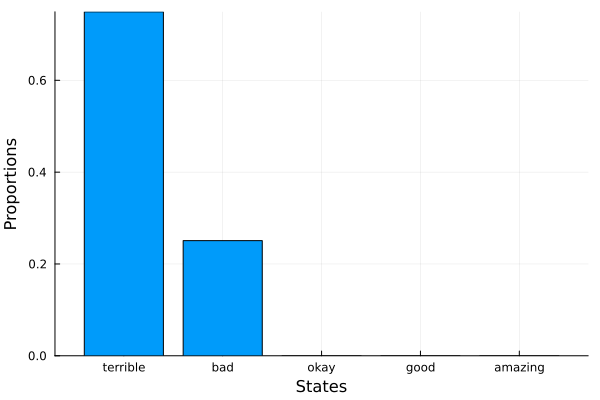

In [264]:
bar(utterances, results.latent_probs[:utter], xlabel="States", ylabel="Proportions", legend=false)

### L1

In [256]:
# Save S1's probabilities for different states and phis for fast later access

utterProbsDict(state, phi, utterances) = Dict(utterance => prob for (utterance, prob) in zip(utterances, enum_inference(speaker1, (state, phi), observations, (:utter, ), (utterances, )).latent_probs[:utter]))
phiVals = collect(0.05:0.05:0.95)
phiProbs = uniformProbs(phiVals)
utterances = ["terrible", "bad", "okay", "good", "amazing"]
S1_posterior_map = Dict((state, phi) => utterProbsDict(state, phi, utterances) for state in states for phi in phiVals)

Dict{Tuple{Int64, Float64}, Dict{String, Float64}} with 95 entries:
  (3, 0.7)  => Dict("okay"=>0.914341, "amazing"=>5.93269e-10, "terrible"=>4.25759e-15, "bad"=>5.208…
  (1, 0.8)  => Dict("okay"=>7.81828e-13, "amazing"=>1.031e-10, "terrible"=>0.680353, "bad"=>0.31964…
  (2, 0.15) => Dict("okay"=>0.000532048, "amazing"=>0.973328, "terrible"=>5.77675e-12, "bad"=>1.208…
  (2, 0.75) => Dict("okay"=>0.00299276, "amazing"=>3.83549e-9, "terrible"=>0.267705, "bad"=>0.72930…
  (1, 0.9)  => Dict("okay"=>1.31388e-15, "amazing"=>6.45436e-14, "terrible"=>0.717851, "bad"=>0.282…
  (5, 0.6)  => Dict("okay"=>2.60652e-6, "amazing"=>0.990475, "terrible"=>1.74414e-17, "bad"=>2.2820…
  (3, 0.8)  => Dict("okay"=>0.97804, "amazing"=>4.97687e-12, "terrible"=>1.26731e-15, "bad"=>1.4496…
  (1, 0.3)  => Dict("okay"=>5.39678e-5, "amazing"=>0.992049, "terrible"=>4.81365e-7, "bad"=>5.51907…
  (1, 0.95) => Dict("okay"=>5.37295e-17, "amazing"=>1.61097e-15, "terrible"=>0.735565, "bad"=>0.264…
  (5, 0.55) => Dict("ok

In [257]:
"""
    enumerate_L1(utterance::String, states::Vector{String}, stateProbs::Vector{Float64},
                 phiVals::Vector{String}, phiProbs::Vector{Float64},
                 S1_posterior_map::Dict{Tuple{String, String}, Dict{String, Float64}})

Calculate the posterior probabilities of states and φ (phi) values given an utterance, using an input dict of speaker1 posterior for different inuput values.

# Arguments
- `utterance::String`: A string representing the utterance for which the probabilities are to be calculated.
- `states::Vector{String}`: An array of possible states.
- `stateProbs::Vector{Float64}`: An array of prior probabilities corresponding to each state in `states`.
- `phiVals::Vector{String}`: An array of possible φ (phi) values.
- `phiProbs::Vector{Float64}`: An array of prior probabilities corresponding to each φ (phi) value in `phiVals`.
- `S1_posterior_map::Dict{Tuple{String, String}, Dict{String, Float64}}`: A dictionary mapping tuples of (state, phi) to another dictionary that maps utterances to their probabilities. This map is essential for computing the likelihood of the utterance given each state and φ combination.

# Returns
- `state_probs::Vector{Float64}`: An array containing the normalized probabilities of each state given the utterance, ordered according to the input array `states`.
- `phi_probs::Vector{Float64}`: An array containing the normalized probabilities of each φ (phi) value given the utterance, ordered according to the input array `phiVals`.

"""

function enumerate_L1(utterance::String, states::Vector{String}, stateProbs::Vector{Float64},
                 phiVals::Vector{String}, phiProbs::Vector{Float64},
                 S1_posterior_map::Dict{Tuple{String, String}, Dict{String, Float64}})
    # Initialize arrays to accumulate log probabilities, setting initial values to -Inf for log space addition
    state_log_probs = fill(-Inf, length(states))
    phi_log_probs = fill(-Inf, length(phiVals))

    # Iterate over all states and phi values
    for (i, state) in enumerate(states)
        for (j, phi) in enumerate(phiVals)
            # Retrieve the probability of the utterance given state and phi from the precomputed S1 model
            prob_utterance_given_state_phi = get(S1_posterior_map[(state, phi)], utterance, 0)
            log_prob_utterance_given_state_phi = prob_utterance_given_state_phi > 0 ? log(prob_utterance_given_state_phi) : -Inf

            # Calculate the total log probability including the priors
            log_prob = log(stateProbs[i]) + log(phiProbs[j]) + log_prob_utterance_given_state_phi

            # Accumulate log probabilities
            state_log_probs[i] = logsumexp([state_log_probs[i], log_prob])
            phi_log_probs[j] = logsumexp([phi_log_probs[j], log_prob])
        end
    end

    # Normalize the probabilities for states and phi values
    state_probs = normalize_log_probs(state_log_probs)
    phi_probs = normalize_log_probs(phi_log_probs)

    return state_probs, phi_probs
end

# Helper function to normalize log probabilities
function normalize_log_probs(log_probs)
    max_log_prob = logsumexp(log_probs)
    normalized_probs = exp.(log_probs .- max_log_prob)
    return normalized_probs ./ sum(normalized_probs)
end


normalize_log_probs (generic function with 1 method)

In [258]:
# Now we define the pragmtic listener's model

@gen function pragmaticListener(utterance)

    updates_stateProbs, updates_phiProbs = enumerate_L1(utterance, states, stateProbs, phiVals, phiProbs, S1_posterior_map)
    state = @trace(uniformDraw(states, updates_stateProbs), :state)
    phi = @trace(uniformDraw(phiVals, updates_phiProbs), :phi)

    return [state, phi]
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##pragmaticListener#2283", Bool[0], false)

In [259]:
trace = Gen.simulate(pragmaticListener, ("good", ))
Gen.get_choices(trace)

│
├── :state : 4
│
└── :phi : 0.5


In [260]:
# Define observed actions
observations = choicemap()  # We assume no observation here

# Run inference by enumerating over all possible states
results = enum_inference(
    pragmaticListener,
    ("good", ),
    observations,
    (:phi, :state, ),  # latent addresses
    (phiVals, states, )
)

# Print inferred utterance probabilities
println("Inferred state probabilities given our observationns:")
for (utterance, prob) in zip(states, results.latent_probs[:state])
    println("State $utterance: Probability $prob")
end

println("Inferred phi probabilities given our observationns:")
for (utterance, prob) in zip(phiVals, results.latent_probs[:phi])
    println("phi $utterance: Probability $prob")
end

Inferred state probabilities given our observationns:
State 1: Probability 0.006748724522564941
State 2: Probability 0.046345354038252025
State 3: Probability 0.7355414404417936
State 4: Probability 0.19499572052399092
State 5: Probability 0.016368760473398455
Inferred phi probabilities given our observationns:
phi 0.05: Probability 0.005756624636643318
phi 0.1: Probability 0.018053553567811513
phi 0.15: Probability 0.05225099864380687
phi 0.2: Probability 0.08720691717278714
phi 0.25: Probability 0.10099921971298029
phi 0.3: Probability 0.10552211571296734
phi 0.35: Probability 0.10469898922448374
phi 0.4: Probability 0.09561860873855725
phi 0.45: Probability 0.0825149999287843
phi 0.5: Probability 0.0671566210660875
phi 0.55: Probability 0.05101220704475096
phi 0.6: Probability 0.037092712064906656
phi 0.65: Probability 0.027782354506771596
phi 0.7: Probability 0.02329852095184539
phi 0.75: Probability 0.022480033113525238
phi 0.8: Probability 0.024075941806057946
phi 0.85: Probabili

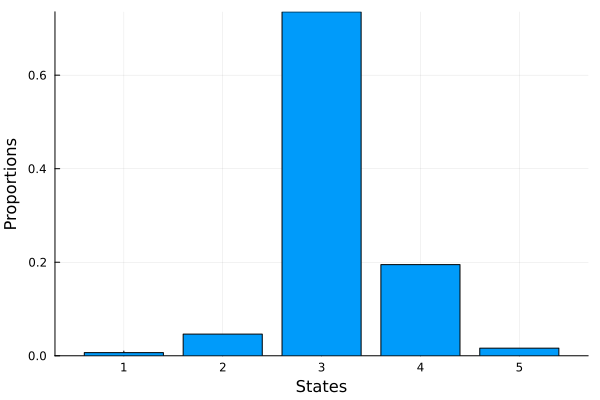

In [261]:
bar(states, results.latent_probs[:state], xlabel="States", ylabel="Proportions", legend=false)

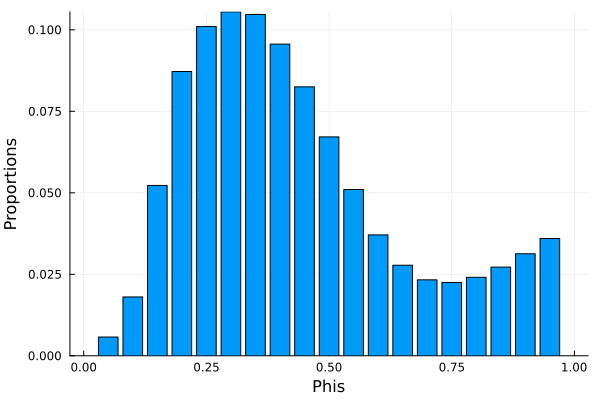

In [262]:
bar(phiVals, L1_post, xlabel="Phis", ylabel="Proportions", legend=false)